In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, GRU, Bidirectional, LSTM, Dropout, BatchNormalization


In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

## 데이터 탐색

In [3]:
train.shape

(16541, 7)

In [4]:
test.shape

(7090, 2)

In [5]:
train.head()

,ID,문장,유형,극성,시제,확실성,label
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실


In [6]:
test.head()

,ID,문장
0,TEST_0000,"장욱진의 ＇가족＇은 허물 없는 가족애를, 처음 공개되는 정약용의 ＇정효자전＇과 ＇정..."
1,TEST_0001,"조지 W 부시, 버락 오바마 전 대통령도 전쟁 위험 때문에 버린 카드다."
2,TEST_0002,지난해 1분기 128억원이었던 영업이익이 올해 1분기 505억원으로 급증했다.
3,TEST_0003,수상 작가와 맺으려던 계약서 내용 가운데 일부가 ＇독소 조항＇으로 해석돼 수정을 요...
4,TEST_0004,결국 최근 KDB산업은행은 대규모 손실 위기에 닥친 에어부산에 140억원 금융지원을...


In [7]:
train["label"].value_counts()

사실형-긍정-과거-확실     7113
사실형-긍정-현재-확실     4743
추론형-긍정-현재-확실     1101
사실형-긍정-미래-확실      649
추론형-긍정-과거-확실      335
                 ... 
대화형-미정-과거-확실        1
예측형-미정-현재-확실        1
예측형-부정-현재-불확실       1
예측형-부정-과거-확실        1
예측형-미정-과거-확실        1
Name: label, Length: 64, dtype: int64

## 데이터 전처리

In [8]:
label_name = "label"

In [9]:
X_trian = train["문장"]
X_trian.shape

(16541,)

In [10]:
X_test = test["문장"]
X_test.shape

(7090,)

In [11]:
y = train[label_name]
y.shape

(16541,)

In [13]:
y_ohe = pd.get_dummies(y)
y_ohe.head()

,대화형-긍정-과거-불확실,대화형-긍정-과거-확실,대화형-긍정-미래-불확실,대화형-긍정-미래-확실,대화형-긍정-현재-불확실,대화형-긍정-현재-확실,대화형-미정-과거-불확실,대화형-미정-과거-확실,대화형-미정-미래-불확실,대화형-미정-미래-확실,...,추론형-미정-미래-불확실,추론형-미정-미래-확실,추론형-미정-현재-불확실,추론형-미정-현재-확실,추론형-부정-과거-불확실,추론형-부정-과거-확실,추론형-부정-미래-불확실,추론형-부정-미래-확실,추론형-부정-현재-불확실,추론형-부정-현재-확실
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
y_ohe.shape

(16541, 64)

In [133]:
# train_test_split 으로 학습과 예측에 사용할 데이터 나누기
X_train_text, X_valid_text, y_train, y_valid = train_test_split(
    X_trian, y_ohe, test_size=0.2, random_state=42)

X_train_text.shape, X_valid_text.shape, y_train.shape, y_valid.shape

((13232,), (3309,), (13232, 64), (3309, 64))

## 문장 Tokenizer

In [134]:
# vocab_size = 40063
oov_tok = "<oov>"
tokenizer = Tokenizer(num_words=None, oov_token = oov_tok)
tokenizer

In [135]:
tokenizer.fit_on_texts(X_train_text)

In [136]:
len(tokenizer.word_index)

77426

In [137]:
# 단어별 빈도수 확인
list(tokenizer.word_counts.items())[:5]

[('화양정', 1), ('서울', 144), ('성동구', 1), ('살곶이목장', 1), ('내에', 12)]

In [138]:
# 단어별 빈도수 확인
pd.DataFrame(tokenizer.word_counts.items()).set_index(0).nlargest(10, 1).T

,있다,수,등,있는,이,한,통해,지난,위해,것으로
1,1363,1356,816,757,637,482,445,383,381,380


In [139]:
# texts_to_sequences를 이용하여 text 문장을 숫자로 이루어진 리스트로 변경합니다.
train_sequences = tokenizer.texts_to_sequences(X_train_text)
valid_sequences = tokenizer.texts_to_sequences(X_valid_text)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [140]:
len(test_sequences[0])

27

In [141]:
len(train_sequences[0])

22

In [142]:
train_sequences[0][:10]

[23043, 73, 23044, 23045, 1824, 454, 23046, 1053, 23047, 3460]

## Paddding

In [143]:
train["문장"].map(lambda x : len(x.split())).describe()

count    16541.000000
mean        14.707091
std          8.086563
min          2.000000
25%          9.000000
50%         13.000000
75%         18.000000
max        124.000000
Name: 문장, dtype: float64

In [144]:
# 문장의 길이가 제각각인 벡터의 크기를 패딩 작업을 통해 나머지 빈 공간을 0으로 채워줍니다.

max_length = 100
padding_type = "post"

X_train_sp = pad_sequences(train_sequences, padding='post', maxlen=max_length)
X_valid_sp = pad_sequences(valid_sequences, padding='post', maxlen=max_length)
X_test_sp = pad_sequences(test_sequences, padding='post', maxlen=max_length)

## Modeling

In [145]:
embedding_dim = 64

In [146]:
n_class = y_train.shape[1]
n_class

64

In [147]:
# 모델 레이어 구성
model = Sequential()
model.add(Embedding(input_dim=77427, 
                    output_dim=embedding_dim, 
                    input_length=max_length))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation = "relu"))
model.add(Dense(n_class, activation="softmax"))

In [148]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 64)           4955328   
                                                                 
 bidirectional_27 (Bidirecti  (None, 100, 256)         197632    
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 100, 256)          0         
                                                                 
 bidirectional_28 (Bidirecti  (None, 100, 256)         394240    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 100, 256)          0         
                                                                 
 bidirectional_29 (Bidirecti  (None, 128)             

## 모델 컴파일

In [149]:
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

## 학습

In [150]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [151]:
history = model.fit(X_train_sp, y_train,
                    validation_data=(X_valid_sp, y_valid), epochs=5)

Epoch 1/5


2022-12-17 18:28:09.128864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:28:09.852057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:28:09.872790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:28:10.268541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:28:10.289314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:28:10.669606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:28:10.686587: I tensorflow/core/grappler/optimizers/cust

414/414 [==============================] - ETA: 0s - loss: 1.9843 - accuracy: 0.4142

2022-12-17 18:29:28.012877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:29:28.280062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:29:28.293088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:29:28.606521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:29:28.619643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:29:28.941517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:29:28.954253: I tensorflow/core/grappler/optimizers/cust

414/414 [==============================] - 93s 206ms/step - loss: 1.9843 - accuracy: 0.4142 - val_loss: 1.9067 - val_accuracy: 0.4397
Epoch 2/5
414/414 [==============================] - 87s 210ms/step - loss: 1.9147 - accuracy: 0.4247 - val_loss: 1.8778 - val_accuracy: 0.4397
Epoch 3/5
414/414 [==============================] - 85s 204ms/step - loss: 1.6814 - accuracy: 0.5434 - val_loss: 1.7270 - val_accuracy: 0.5234
Epoch 4/5
414/414 [==============================] - 84s 202ms/step - loss: 1.2892 - accuracy: 0.6654 - val_loss: 1.7757 - val_accuracy: 0.5225
Epoch 5/5
414/414 [==============================] - 84s 203ms/step - loss: 1.0068 - accuracy: 0.7411 - val_loss: 2.3198 - val_accuracy: 0.4630


In [152]:
df_hist = pd.DataFrame(history.history)
df_hist.head()

,loss,accuracy,val_loss,val_accuracy
0,1.984274,0.414223,1.906744,0.439710
1,1.914735,0.424652,1.877803,0.439710
2,1.681365,0.543380,1.726954,0.523421
3,1.289208,0.665357,1.775698,0.522514
4,1.006786,0.741082,2.319824,0.462980


<AxesSubplot: >

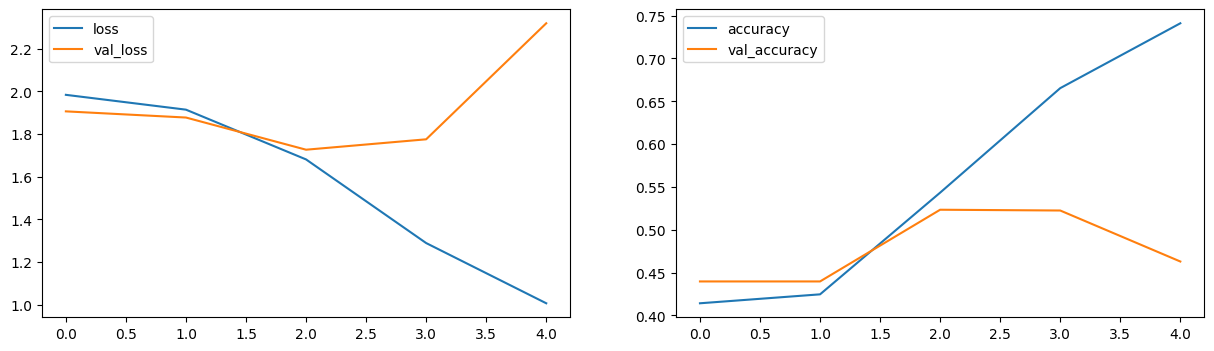

In [153]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
df_hist[["loss", "val_loss"]].plot(ax=axes[0])
df_hist[["accuracy", "val_accuracy"]].plot(ax=axes[1])

## 예측

In [154]:
y_pred = model.predict(X_test_sp)
y_pred

2022-12-17 18:35:19.115500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:35:19.354192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:35:19.374064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:35:19.716092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:35:19.728554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:35:20.030812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 18:35:20.043579: I tensorflow/core/grappler/optimizers/cust

222/222 [==============================] - 17s 71ms/step


array([[2.4944075e-04, 2.6771293e-03, 9.7453696e-05, ..., 2.9296651e-05,
        6.0165250e-05, 6.2855199e-04],
       [1.2931852e-04, 9.7579585e-04, 4.2046020e-05, ..., 1.7300454e-05,
        4.5047171e-05, 1.8734680e-04],
       [8.4027312e-07, 7.9842048e-06, 1.0030323e-07, ..., 6.5493410e-08,
        2.5080482e-07, 3.5058474e-07],
       ...,
       [2.9898232e-05, 4.2546628e-04, 8.0813070e-06, ..., 2.4425929e-06,
        7.8623971e-06, 6.4989516e-05],
       [6.2627615e-03, 2.6107010e-02, 6.7054317e-03, ..., 2.7440074e-03,
        3.3826318e-03, 2.6248345e-02],
       [5.1923831e-05, 7.4911048e-04, 1.5746798e-05, ..., 4.6866789e-06,
        1.2283381e-05, 1.2373539e-04]], dtype=float32)

In [155]:
y_pred.shape

(7090, 64)

In [156]:
y_predict = np.argmax(y_pred, axis=1)
y_predict

array([21, 21, 17, ..., 21, 52, 21])

In [157]:
submit = pd.read_csv("./data/sample_submission.csv")
submit.head()

,ID,label
0,TEST_0000,추론형-긍정-현재-확실
1,TEST_0001,추론형-긍정-현재-확실
2,TEST_0002,추론형-긍정-현재-확실
3,TEST_0003,추론형-긍정-현재-확실
4,TEST_0004,추론형-긍정-현재-확실


In [158]:
y_label = []

for i in y_predict:
    y_label.append(y_ohe.columns[i])

y_label

['사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-과거-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-과거-확실',
 '추론형-긍정-현재-확실',
 '추론형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-과거-확실',
 '사실형-긍정-과거-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-과거-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '추론형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-과거-확실',
 '추론형-긍정-현재-확실',
 '사실형-긍정-과거-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-과거-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-과거-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-과거-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-과거-확실',
 '사실형-긍정-과거-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '추론형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '추론형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-과거-확실',
 '사실형-긍정-과거-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-과거-확실',
 '추론형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-과거-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실',
 '사실형-긍정-현재-확실

In [160]:
submit["label"]= y_label

In [161]:
submit.head()

,ID,label
0,TEST_0000,사실형-긍정-현재-확실
1,TEST_0001,사실형-긍정-현재-확실
2,TEST_0002,사실형-긍정-과거-확실
3,TEST_0003,사실형-긍정-현재-확실
4,TEST_0004,사실형-긍정-과거-확실


In [162]:
submit.to_csv("./data/submit1.csv", index = False)